In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

2023-07-06 10:35:33.900796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 10:35:38.832968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 10:35:38.835197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 10:35:49.350705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.12.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import random

In [3]:
import os
os.chdir('/gstore/project/hr_brca_heterogeneity/T47D_trace_Seq_v2/Nathan')
#os.listdir()

In [4]:
'''Hyperparameters'''

batch_size = 32 # was 32
seq_len = 8 # was 128

#d_k = 256
#d_v = 256
n_heads = 40 # was 60  # Number of attention heads # no difference or imporvement between 5-60
n_head_size= 5 # was 46 # Embedding size for attention # no difference between 5-46
n_ff_dim = 5  # was 55    # Hidden layer size in feed forward network inside transformer # some difference between 5-55


In [5]:
#### full data
import json

# f = open('tran_9545_barcodes2.json') is 25% cells have count of 3 or more (RT-PT)
# f = open('tran_9545_barcodes3.json') is 10% cells have count of 1 or more (RT-PT)
# f = open('tran_9545_barcodes4.json') is PTIME ONLY order with 10% cells have count of 1 or more
# f = open('tran_9545_barcodes5.json') is PTIME ONLY order AND P-SURV with 10% cells have count of 1 or more
# f = open('tran_9545_barcodes6.json') is PLSR PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_9545_barcodes8.json') is PLSR BREASTcgp + ESRcgp Paths PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_9545_barcodes9.json') is PLSR PID + HALLMARK Paths PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_Palbo_barcodes.json') is palbo PLSR genes PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_Palbo_barcodes.json') is combo PLSR genes PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
f = open('tran_9545_barcodes6.json')
data = json.load(f)

In [6]:
exp_days = {'Day 0': 1, 'Day 1': 2, 'Day 4': 3, 'Day 8': 4, 'Day 26': 5}

df = pd.DataFrame(data['GFPBC_libB_92196'])
df.iloc[:, 0:len(df.columns)-1]

,Pseudotime,RealTime,Survival,HES4,SDF4,MXRA8,AURKAIP1,MRPL20,SSU72,GNB1,...,HMGB3,CETN2,BCAP31,SSR4,NAA10,TKTL1,RPL10,ATP6AP1,FAM50A,LAGE3
0,28.6919,2,0.9327,1.4547,2.1641,0.0000,2.9935,2.9935,0.0000,2.6376,...,1.4547,1.4547,1.4547,2.9935,2.1641,0.0000,0.0000,3.2787,0.0000,2.1641
1,28.6943,2,0.9318,1.1159,1.1159,1.4600,3.0007,1.4600,2.6446,1.1159,...,1.1159,1.1159,1.9703,2.1706,1.1159,1.1159,2.8915,1.7376,1.1159,1.7376
2,28.7700,2,0.9360,1.4554,2.1649,0.0000,2.6385,2.1649,2.1649,0.0000,...,2.1649,1.4554,1.4554,2.9944,1.4554,0.0000,3.9009,2.6385,2.1649,2.1649
3,28.7809,2,0.9350,1.9830,1.3083,2.4408,1.3083,1.9830,2.7879,1.3083,...,0.0000,0.0000,0.0000,4.1078,0.0000,1.9830,3.5028,0.0000,0.0000,0.0000
4,28.8275,2,0.9353,1.7730,1.3851,0.8527,2.5448,2.7315,2.7315,2.3304,...,1.3851,1.3851,2.0785,2.8967,0.0000,1.7730,2.0785,1.7730,1.3851,2.0785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2728,66.9579,4,0.9039,3.3126,1.9922,0.0000,3.8483,3.0783,2.4510,1.3157,...,2.4510,0.0000,1.3157,3.3126,2.4510,1.3157,2.4510,1.9922,2.4510,0.0000
2729,66.9822,4,0.8987,2.5026,0.0000,0.0000,3.1340,3.0001,3.1340,0.0000,...,0.0000,2.2896,2.0396,3.7491,2.0396,0.0000,3.1340,2.2896,1.3537,1.7371
2730,67.0225,4,0.8903,2.9839,2.9839,1.4477,3.2688,1.4477,3.2688,0.0000,...,2.1556,1.4477,2.1556,3.5067,2.6284,0.0000,2.1556,2.1556,1.4477,2.1556
2731,67.0310,4,0.8759,2.9740,2.4232,0.6990,3.1865,2.7248,2.9740,1.1679,...,0.6990,0.6990,1.5211,3.4560,2.0416,0.0000,3.0842,2.0416,2.0416,1.8047


In [7]:
barcodes = [i for i in data.keys()]
new_barcodes = []
for i in barcodes:
    df = pd.DataFrame(data[i])
    #print(i, df.shape[0])
    if df.shape[0] > 400: # 50 or 60
        new_barcodes.append(i)
print(new_barcodes)

bar_dict = {new_barcodes[i]:i for i in range(len(new_barcodes))}

['GFPBC_libB_83026', 'GFPBC_libB_40758', 'GFPBC_libB_20182', 'GFPBC_libB_90850', 'GFPBC_libB_37798', 'GFPBC_libB_92196', 'GFPBC_libB_10678', 'GFPBC_libB_94397', 'GFPBC_libB_31581']


In [8]:
'''Create training and test data'''

def transformer_train_test_split_dayiter(bar, frac_val, extra_var_bool, splitval):
    
    bardf = pd.DataFrame(data[bar])
    #bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf['RealTime'].tolist())
    snum = int(num_cell_day*splitval)
    bardf = bardf.iloc[:snum,:]
    
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2['RealTime'].tolist())
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
    #bardf2 = bardf2.dropna()
    COLS = bardf2.columns.tolist()[1:]
    #print(COLS)
    
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    #print(bardf_val)
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    
    # Training data
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
      X_train.append(train_data[i-seq_len:i]) 
      y_train.append(train_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Validation data
    X_val, y_val = [], []
    for i in range(seq_len, len(val_data)):
      X_val.append(val_data[i-seq_len:i]) 
      y_val.append(val_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    print('Transformer Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val, COLS

In [9]:
'''Create training and test data'''

def regr_train_test_split_dayiter(bar, frac_val, extra_var_bool, splitval):
    
    bardf = pd.DataFrame(data[bar])
    #bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf['RealTime'].tolist())
    snum = int(num_cell_day*splitval)
    bardf = bardf.iloc[:snum,:]
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2['RealTime'].tolist())
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
        
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    #print(bardf_val)
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    
    # Training data
    X_train, y_train = np.array(train_data), np.array(train_y)
    
    # Validation data
    X_val, y_val = np.array(val_data), np.array(val_y)
    
    print('Regr Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val

In [10]:
########### testing function #################
# make the training and validation data

b = 'GFPBC_libB_92196'
frac_val = 0.20
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime
vs = [0.25, 0.5, 0.75, 1]
pct_test = frac_val/len(vs)
for v in vs:
    X_train, y_train, X_val, y_val, cols = transformer_train_test_split_dayiter(b, pct_test, extra_var_bool, v)
    #X_train, y_train, X_val, y_val = regr_train_test_split_dayiter(b, pct_test, extra_var_bool, v)


Transformer Training/Val set shapes (varies depending on barcode)  (538, 8, 1969) (129, 8, 1969)
Transformer Training/Val set shapes (varies depending on barcode)  (1221, 8, 1969) (129, 8, 1969)
Transformer Training/Val set shapes (varies depending on barcode)  (1904, 8, 1969) (129, 8, 1969)
Transformer Training/Val set shapes (varies depending on barcode)  (2588, 8, 1969) (129, 8, 1969)


In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        # "EMBEDDING LAYER"
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)

        # "ATTENTION LAYER"
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        x = layers.Dropout(dropout)(x)
        res = x + inputs
    
    for _ in range(num_transformer_blocks):
        # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0, 
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # This is what stacks our transformer blocks
    x = transformer_encoder(x, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [13]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [14]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [15]:
from keras.utils.vis_utils import plot_model
import pydot
import graphviz

#tf.keras.utils.plot_model(model, to_file ='model_plot.png', show_shapes = True, show_layer_names = True)

In [16]:
b = 'GFPBC_libB_92196'
frac_val = 0.20
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime
vs = [0.25, 0.5, 0.75, 1]
pct_test = frac_val/len(vs)
X_train, y_train, X_val, y_val, cols = transformer_train_test_split_dayiter(b, pct_test, extra_var_bool, 1)

Transformer Training/Val set shapes (varies depending on barcode)  (2588, 8, 1969) (129, 8, 1969)


In [17]:

k = 1
j = 2
print('k', X_val[:,:,k])
print('\n\nj')
print(X_val[:,:,j])
print('\n\nkj')
print(X_val[:,:, [k, j]])
save_col = X_val[:,:,[k, j]].copy()
np.random.shuffle(X_val[:,:,k])
np.random.shuffle(X_val[:,:,j])
print('\n\nnew')
print(save_col.shape)
print('k', X_val[:,:,k])
print('\n\nj')
print(X_val[:,:,j])
print('\n\nkj')
print(X_val[:,:,[k, j]])

X_val[:,:,[k, j]] = save_col
print(X_val[:,:,[k, j]])

k [[ 0.15069556 -1.         -0.51277504 ...  0.1239816  -0.24075819
  -0.48933104]
 [-1.         -0.51277504 -1.         ... -0.24075819 -0.48933104
  -1.        ]
 [-0.51277504 -1.         -0.18893754 ... -0.48933104 -1.
   0.20794768]
 ...
 [-1.          0.56858616  0.21288034 ...  0.0359142   0.10414011
  -1.        ]
 [ 0.56858616  0.21288034  0.16399712 ...  0.10414011 -1.
   0.65377155]
 [ 0.21288034  0.16399712  0.04976999 ... -1.          0.65377155
   0.34301391]]


j
[[ 0.21191956  0.30111199 -0.48685171 ...  0.18378426  0.678487
  -0.13656131]
 [ 0.30111199 -0.48685171 -0.03972215 ...  0.678487   -0.13656131
  -1.        ]
 [-0.48685171 -0.03972215  0.26947436 ... -0.13656131 -1.
  -0.34500773]
 ...
 [-0.20584887 -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -0.15494849]
 [-1.         -1.          0.36794793 ... -1.         -0.15494849
  -0.59197969]]


kj
[[[ 0.15069556  0.21191956]
  [-1.          0.3

In [18]:
def SHAPinteraction(X_val, y_val, bar, COLS, dir_path):
    
    #COLS = bardf.columns.tolist()[1:] # may need fixing
    #print(len(COLS), X_val.shape)
    #print(COLS)

    results = []
    print(' Computing feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X_val, verbose=0).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y_val ))
    results.append({'feature':'BASELINE','mae':baseline_mae})           

    for k in range(110, len(COLS)):

        print('SHAP', k)
            
        for j in range(len(COLS)):
        
            # SHUFFLE FEATURE K AND J
            save_col = X_val[:,:,[k, j]].copy()
            np.random.shuffle(X_val[:,:,k])
            np.random.shuffle(X_val[:,:,j])

            # COMPUTE OOF MAE WITH FEATURE K AND J SHUFFLED
            oof_preds = model.predict(X_val, verbose=0).squeeze() 
            mae = np.mean(np.abs( oof_preds-y_val ))
            results.append({'feature_pair':COLS[k]+'_'+COLS[j],'mae':mae})
            X_val[:,:,[k, j]] = save_col

        print()
        df = pd.DataFrame(results)
        df = df.sort_values('mae')

        # SAVE FEATURE INTERACTIONS
        df = df.sort_values('mae',ascending=False)
        df['fc_mae'] = df['mae'] - baseline_mae
        df.to_csv(dir_path+bar+'_feature_interaction110_unknown.csv',index=False)

In [19]:
def plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, dir_path):
    
    #Calculate predication for training, validation and test data
    print(X_train.shape, X_val.shape)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    #Print evaluation metrics for all datasets
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    print(' ')
    print('Transformer Evaluation metrics')
    print('Transformer Training MSE - MSE: {:.4f}'.format(train_mse)) ### these lines should be MSE???
    print('Transformer Validation MSE - MSE: {:.4f}'.format(val_mse))
    

    plt.plot(y_train, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title("Transformer Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_val, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title("Transformer Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_mse, val_mse

In [20]:
def plot_regr_predictions_losses(X_train, y_train, X_val, y_val, bar, dir_path):
    
    #Calculate predication for training, validation and test data
    train_pred = regr.predict(X)
    val_pred = regr.predict(X_test)

    #Print evaluation metrics for all datasets
    train_eval = mean_squared_error(y, train_pred)
    val_eval = mean_squared_error(y_test, val_pred)
    print(' ')
    print('Evaluation metrics Regr')
    print('Regr Training Data - MSE: {:.4f}'.format(train_eval)) ### these lines should be MSE???
    print('Regr Validation Data - MSE: {:.4f}'.format(val_eval))
    
    plt.plot(y, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title("Regr Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_test, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title("Regr Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_eval, val_eval

In [21]:
# set seeds produces more similar results, but not exact
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)




GFPBC_libB_92196
Transformer Training/Val set shapes (varies depending on barcode)  (538, 8, 1969) (129, 8, 1969)
Epoch 1/5
17/17 [==============================] - 6s 76ms/step - loss: 0.3573 - mean_squared_error: 0.3573 - val_loss: 0.9634 - val_mean_squared_error: 0.9634
Epoch 2/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0779 - mean_squared_error: 0.0779 - val_loss: 1.0849 - val_mean_squared_error: 1.0849
Epoch 3/5
17/17 [==============================] - 1s 40ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 1.2741 - val_mean_squared_error: 1.2741
Epoch 4/5
17/17 [==============================] - 1s 40ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 1.2415 - val_mean_squared_error: 1.2415
Epoch 5/5
17/17 [==============================] - 1s 39ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 1.2154 - val_mean_squared_error: 1.2154
(538, 8, 1969) (129, 8, 1969)
5/5 [==============================] - 0s 10ms/step
 

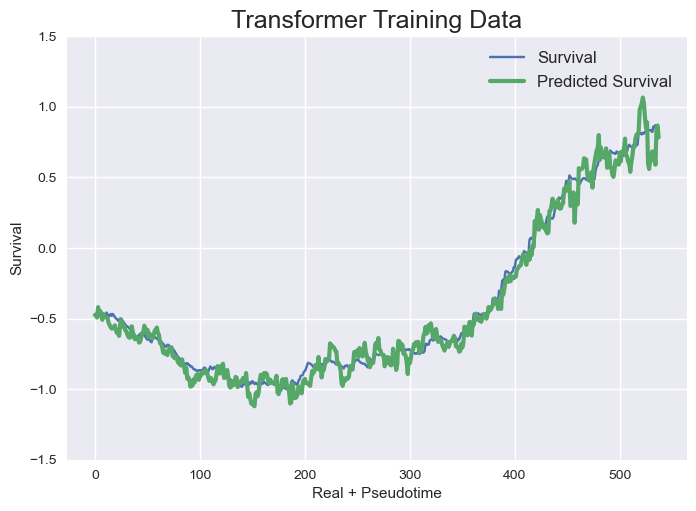

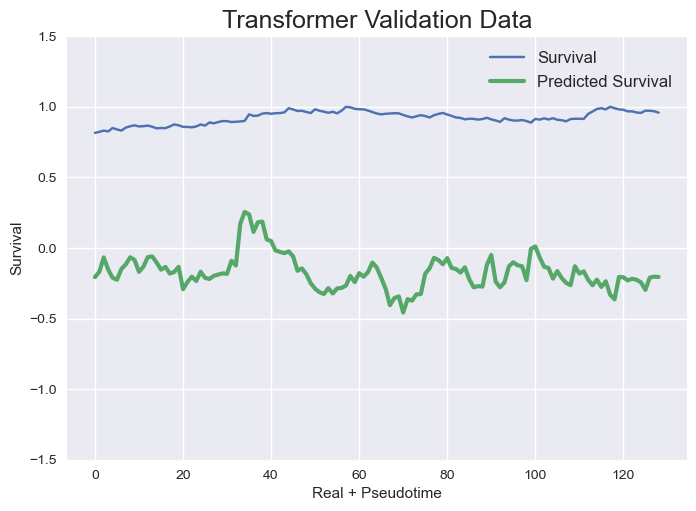

Regr Training/Val set shapes (varies depending on barcode)  (546, 1969) (137, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.8920


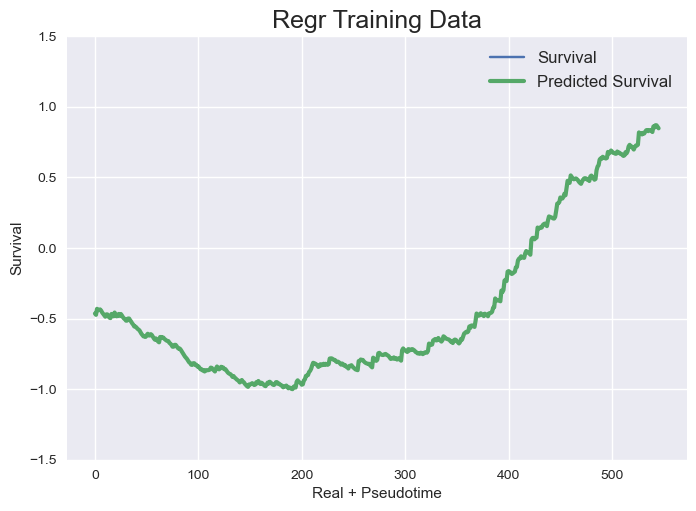

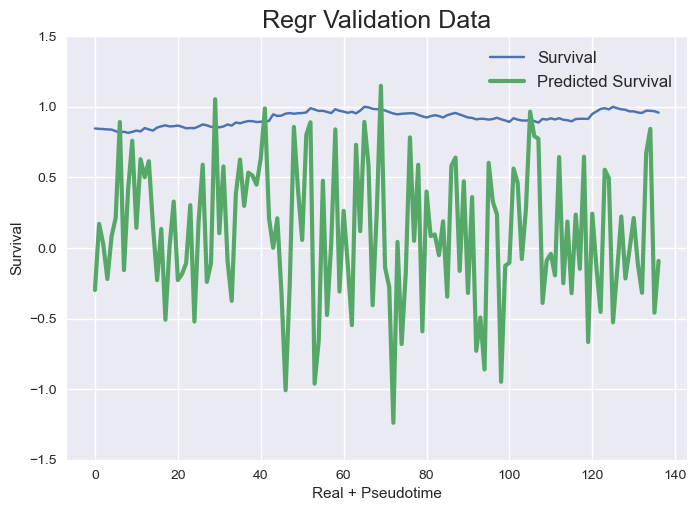

Transformer Training/Val set shapes (varies depending on barcode)  (1221, 8, 1969) (129, 8, 1969)
Epoch 1/5
39/39 [==============================] - 3s 44ms/step - loss: 0.2045 - mean_squared_error: 0.2045 - val_loss: 0.1081 - val_mean_squared_error: 0.1081
Epoch 2/5
39/39 [==============================] - 1s 35ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 3/5
39/39 [==============================] - 1s 36ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.1218 - val_mean_squared_error: 0.1218
Epoch 4/5
39/39 [==============================] - 1s 36ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - val_loss: 0.1210 - val_mean_squared_error: 0.1210
Epoch 5/5
39/39 [==============================] - 1s 35ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - val_loss: 0.0687 - val_mean_squared_error: 0.0687
(1221, 8, 1969) (129, 8, 1969)
5/5 [==============================] - 0s 10ms/step
 
Transformer Evalu

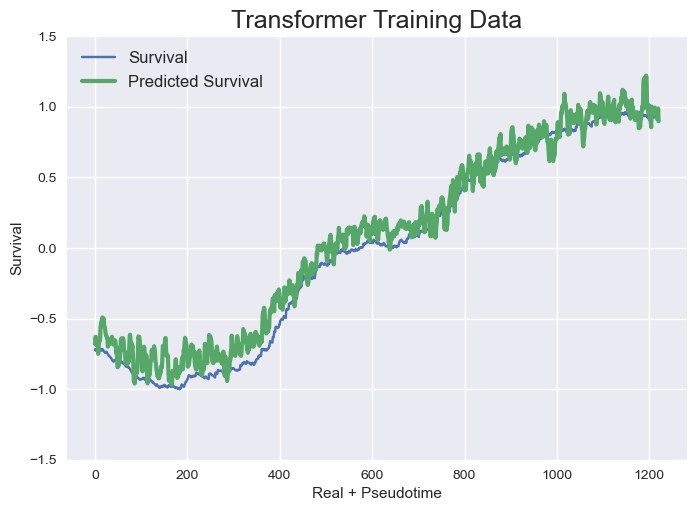

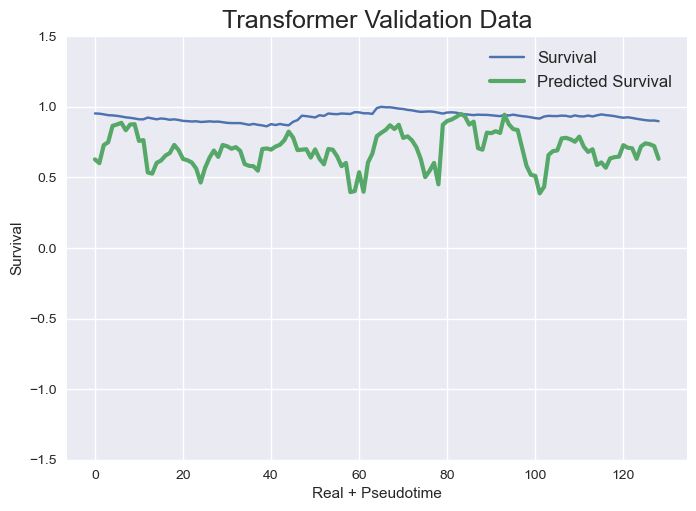

Regr Training/Val set shapes (varies depending on barcode)  (1229, 1969) (137, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.6243


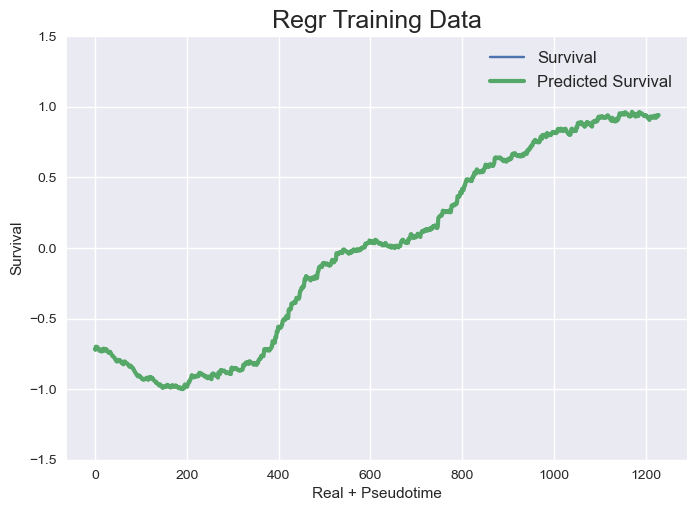

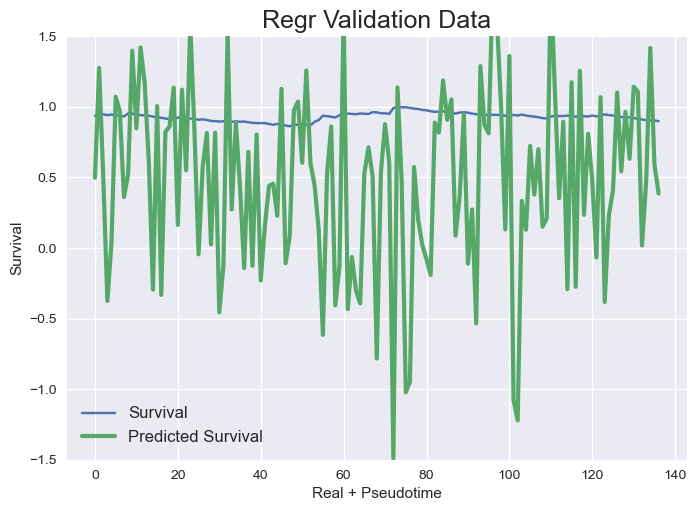

Transformer Training/Val set shapes (varies depending on barcode)  (1904, 8, 1969) (129, 8, 1969)
Epoch 1/5
60/60 [==============================] - 5s 40ms/step - loss: 0.1765 - mean_squared_error: 0.1765 - val_loss: 0.1349 - val_mean_squared_error: 0.1349
Epoch 2/5
60/60 [==============================] - 2s 34ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Epoch 3/5
60/60 [==============================] - 2s 34ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0899 - val_mean_squared_error: 0.0899
Epoch 4/5
60/60 [==============================] - 2s 34ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0832 - val_mean_squared_error: 0.0832
Epoch 5/5
60/60 [==============================] - 2s 34ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.1663 - val_mean_squared_error: 0.1663
(1904, 8, 1969) (129, 8, 1969)
5/5 [==============================] - 0s 10ms/step
 
Transformer Evalu

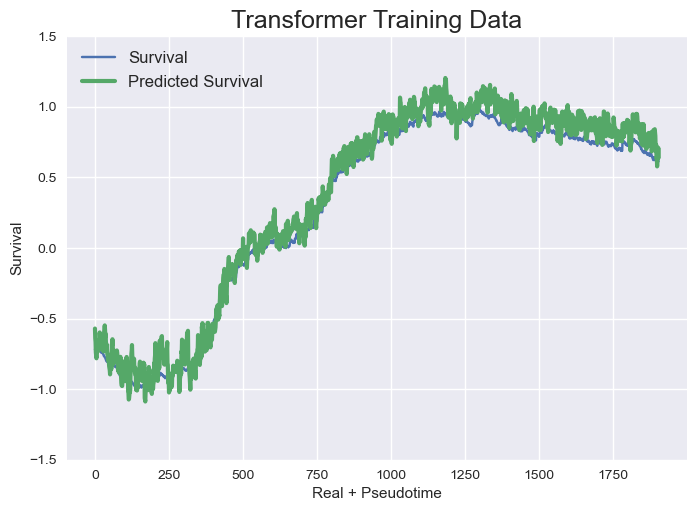

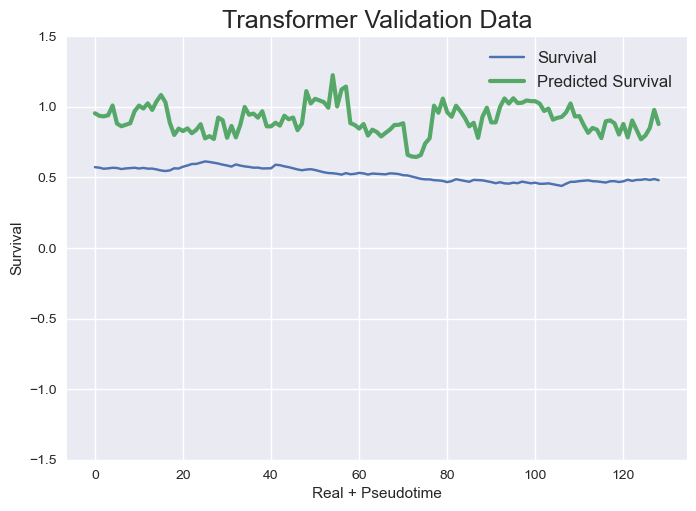

Regr Training/Val set shapes (varies depending on barcode)  (1912, 1969) (137, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 8.2203


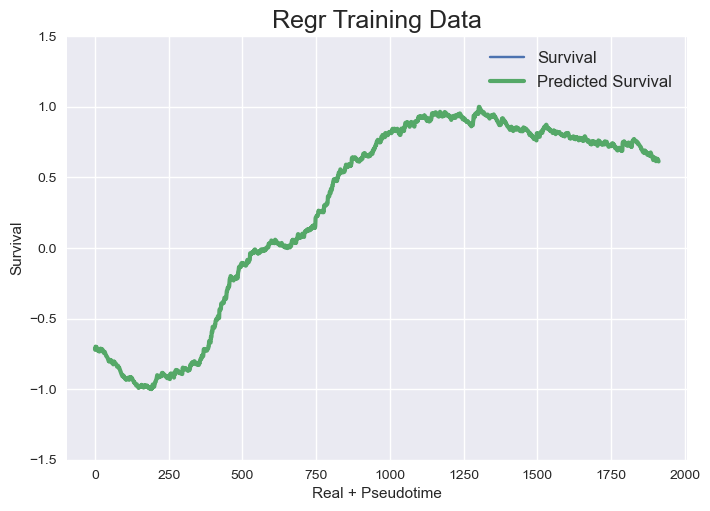

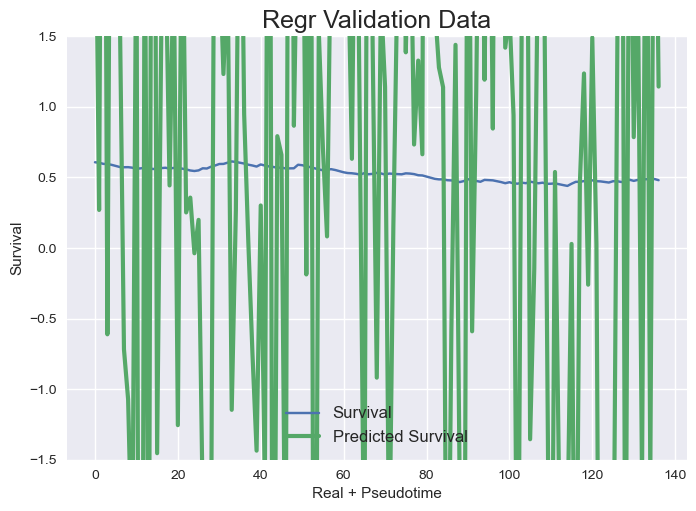

Transformer Training/Val set shapes (varies depending on barcode)  (2588, 8, 1969) (129, 8, 1969)
Epoch 1/5
81/81 [==============================] - 5s 36ms/step - loss: 0.1091 - mean_squared_error: 0.1091 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 2/5
81/81 [==============================] - 3s 34ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.1133 - val_mean_squared_error: 0.1133
Epoch 3/5
81/81 [==============================] - 3s 33ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.1020 - val_mean_squared_error: 0.1020
Epoch 4/5
81/81 [==============================] - 3s 34ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0921 - val_mean_squared_error: 0.0921
Epoch 5/5
81/81 [==============================] - 3s 32ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0721 - val_mean_squared_error: 0.0721
(2588, 8, 1969) (129, 8, 1969)
5/5 [==============================] - 0s 11ms/step
 
Transformer Evalu

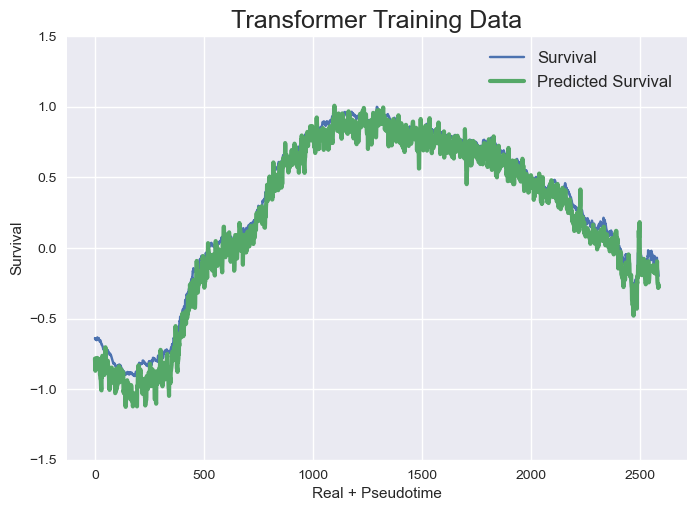

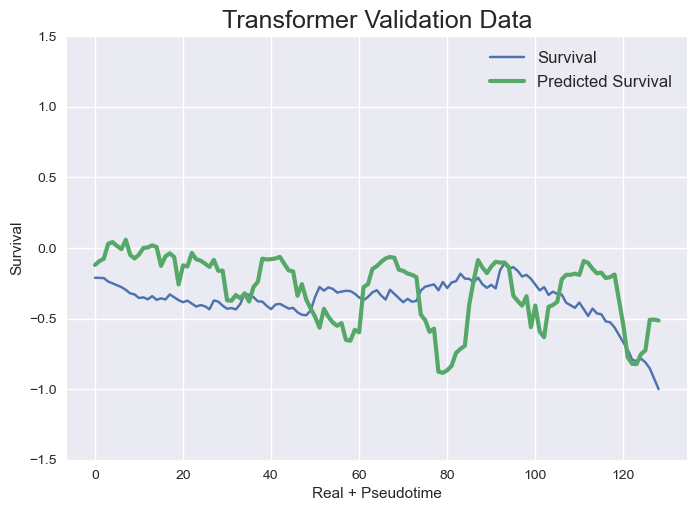

Regr Training/Val set shapes (varies depending on barcode)  (2596, 1969) (137, 1969)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0397
Regr Validation Data - MSE: 0.8072


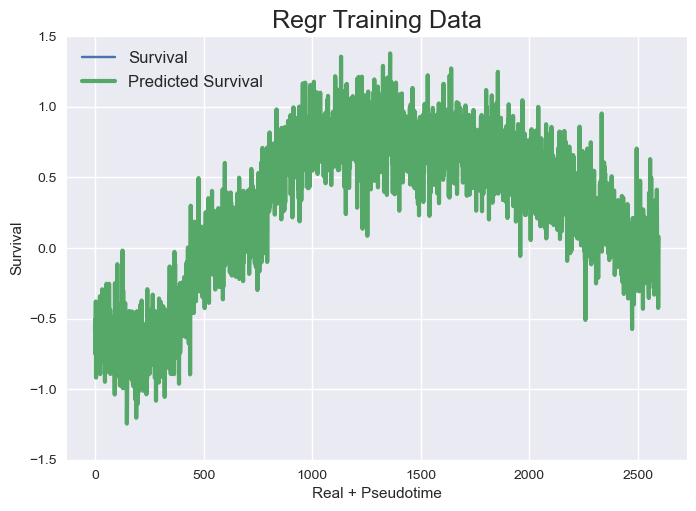

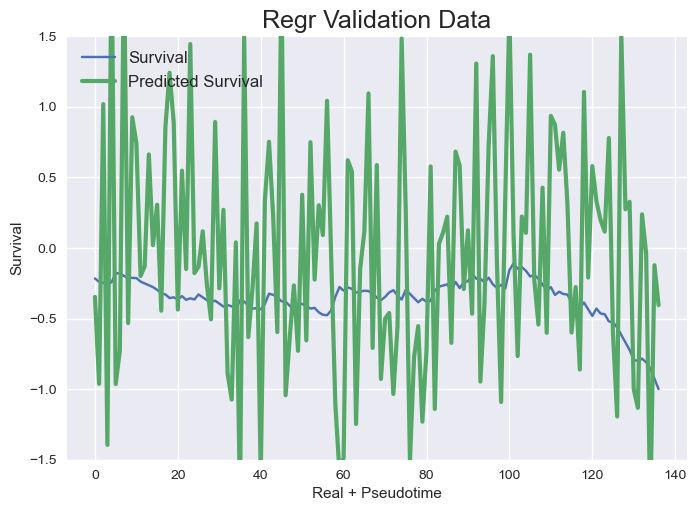

 Computing feature importance...
SHAP 110

SHAP 111

SHAP 112

SHAP 113

SHAP 114

SHAP 115

SHAP 116

SHAP 117

SHAP 118

SHAP 119

SHAP 120

SHAP 121

SHAP 122

SHAP 123

SHAP 124

SHAP 125

SHAP 126

SHAP 127

SHAP 128

SHAP 129

SHAP 130

SHAP 131

SHAP 132

SHAP 133

SHAP 134

SHAP 135

SHAP 136

SHAP 137

SHAP 138

SHAP 139

SHAP 140

SHAP 141

SHAP 142

SHAP 143

SHAP 144

SHAP 145

SHAP 146

SHAP 147

SHAP 148

SHAP 149

SHAP 150

SHAP 151

SHAP 152

SHAP 153

SHAP 154

SHAP 155

SHAP 156

SHAP 157

SHAP 158

SHAP 159

SHAP 160

SHAP 161

SHAP 162

SHAP 163

SHAP 164

SHAP 165

SHAP 166

SHAP 167

SHAP 168


In [ ]:
# use partial_fit to train multiple times, could be different barcodes in our case
frac_val = 0.20
test_bars = ['GFPBC_libB_92196'] #, 'GFPBC_libB_90850', 'GFPBC_libB_20182'] #'GFPBC_libB_78143', 'GFPBC_libB_78143', 'GFPBC_libB_78143']
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime

intervals = [0.25, 0.5, 0.75, 1]
pct_test = frac_val/len(intervals) # comment out and use frac_val for last 20%

mse_dict = {} # structure is {barcode: {day_0: [trans_train, trans_val, regr_train, regr_val], day_n...}, barcode_n: ...}

for bar in test_bars: #new_barcodes:
    
    print('\n\n')
    print(bar)
    mse_dict[bar] = {}
    
    
    for v in intervals:
        # make the training and validation data
        X_train, y_train, X_val, y_val, COLS = transformer_train_test_split_dayiter(bar, pct_test, extra_var_bool, v)

        # build and compile model
        input_shape = X_train.shape[1:]
        model = build_model(
            input_shape,
            head_size=n_head_size, # Embedding size for attention
            num_heads=n_heads, # Number of attention heads
            ff_dim=n_ff_dim, # Hidden layer size in feed forward network inside transformer
            num_transformer_blocks=3, # six layers doesn't add or subtract much so best to keep simple
            mlp_units=[256],
            mlp_dropout=0.4, # unclear if increasing or decreasing has sizable effect
            dropout=0.14 # unclear if increasing or decreasing has sizable effect
        )
        model.compile(
            loss="mean_squared_error",
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # was 1e-4
            metrics=["mean_squared_error"],
        )
        # fit the model
        history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=5,
                        validation_data=(X_val, y_val)) 

        if X_val.shape[0] > 0:

            # predictions and loss
            train_mse, val_mse = plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, 'barmodels_combo/transformer_ptime_')

            # build multivariate regression model
            X, y, X_test, y_test = regr_train_test_split_dayiter(bar, pct_test, extra_var_bool, v)
            regr = linear_model.LinearRegression()
            regr.fit(X, y)
            regr_train_mse, regr_val_mse = plot_regr_predictions_losses(X, y, X_test, y_test, bar, 'barmodels_combo/regr_ptime_')

            # add to mse dictionary
            mse_dict[bar][v] = [train_mse, val_mse, regr_train_mse, regr_val_mse]

            if v == 1:
                # SHAP values
                SHAPinteraction(X_val, y_val, bar, COLS, 'barmodels_ptime9_feature_interaction/transformer_'+str(v))
                

    print(mse_dict[bar])
    
print(mse_dict)